# Multi-dimensional deconvolution with mini-batch stochastic gradient algorithms

In this notebook, we revisit the cost function MDD problem as a finite-sum cost function and we leverage this to solve it by means of minibatch stochastic gradient algorithms implemented in Numpy.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from math import sqrt
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

from mdc import MDC
from stochmdd_numpy import SGD, ExponentialLR, MDDminibatch

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G, Gwav = np.zeros((ns,nr,nt)), np.zeros((ns,nr,nt))
for iy, y0 in enumerate(y):
    G[iy],Gwav[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G, Gwav = G*tap, Gwav*tap

In [3]:
# Add negative part to operator and model
m = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

# Benchmark MDD

In [4]:
def errnorm(m, mtrue, enorm):
    enorm.append(np.linalg.norm(m/m.max() - mtrue/mtrue.max()))

In [5]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, fast=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True)

# Create data
d = MDCop * m.ravel()
d = d.reshape(2*nt-1, ns)

Dot test passed, v^T(Opu)=6055.771163 - u^T(Op^Tv)=6055.771163


In [6]:
# Adjoint
madj = MDCop.H * d.ravel()
madj = np.real(madj)

# CGLS (to be able to track the norm)
niter = 30
enorm = []
minv, istop, itn, r1norm, r2norm, cost = \
    cgls(MDCop, d.ravel(), np.zeros_like(m).ravel(), damp=1e-10, niter=niter, show=1, 
         callback=lambda x: errnorm(x, m.ravel(), enorm))

madj = madj.reshape(2*par['nt']-1, par['nx'])
minv = minv.reshape(2*par['nt']-1, par['nx'])

# modify the residual norm to match with pytorch definition
cost = cost**2 / ((2*par['nt']-1)*par['ny'])

CGLS
-----------------------------------------------------------
The Operator Op has 80699 rows and 48739 cols
damp = 1.000000e-10	tol = 1.000000e-04	niter = 30
-----------------------------------------------------------
    Itn           x[0]              r1norm          r2norm
     1         0.0000e+00         1.8400e+02      1.8400e+02
     2         0.0000e+00         1.2667e+02      1.2667e+02
     3         0.0000e+00         9.6717e+01      9.6717e+01
     4         0.0000e+00         7.7877e+01      7.7877e+01
     5         0.0000e+00         6.3622e+01      6.3622e+01
     6         0.0000e+00         5.4483e+01      5.4483e+01
     7         0.0000e+00         4.6945e+01      4.6945e+01
     8         0.0000e+00         4.0387e+01      4.0387e+01
     9         0.0000e+00         3.5677e+01      3.5677e+01
    10         0.0000e+00         3.2002e+01      3.2002e+01
    20         0.0000e+00         1.4790e+01      1.4790e+01
    21         0.0000e+00         1.3990e+01     

In [7]:
lsqr_minv = minv
lsqr_cost = cost
lsqr_enorm = enorm

# Normal stochastic solvers

In [8]:
#nepochs = 30
#batch_size = 11

nepochs = niter
batch_size = 21

seed = 0
no_of_batches=np.ceil(Gwav2.shape[0]/batch_size)

lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
mdict = {}

In [9]:
# Define max allowed LR
eigmax = (MDCop.H @ MDCop).eigs(neigs=1)
eigmax

Gwav_fft = dr * dt * np.sqrt(2*nt-1) * np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

eigs = np.linalg.eig(np.matmul(np.conj(Gwav_fft.transpose(0,2,1)), Gwav_fft))[0]
eigs = np.fliplr(np.sort(np.abs(eigs), axis=1))

alphamax = 2. / np.real(eigmax[0])

eigs.max(), np.real(eigmax[0]), alphamax

(65139.77574617983, 65139.7757461797, 3.0703206713408056e-05)

## SGD

In [10]:
lr = 2. / (batch_size * (2*nt-1)) # to match torch notebook
print(lr,  alphamax)
model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
              MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, SGD, 
                           nepochs, batch_size,
                           mtrue=m, seed=0,
                           **dict(lr=lr))
mdict["SGD"] = model

0.00011919661481613922 3.0703206713408056e-05
Initial Loss norm: 1.090541e+00
Initial Gradient norm: 4.493770e-02, scaled by lr: 6.384674e-10
epoch:  10, loss : 6.6157e-03, loss avg : 8.7486e-03
epoch:  20, loss : 3.2237e-03, loss avg : 3.6579e-03
epoch:  30, loss : 2.2999e-03, loss avg : 2.2901e-03
Time: 1.276789 s


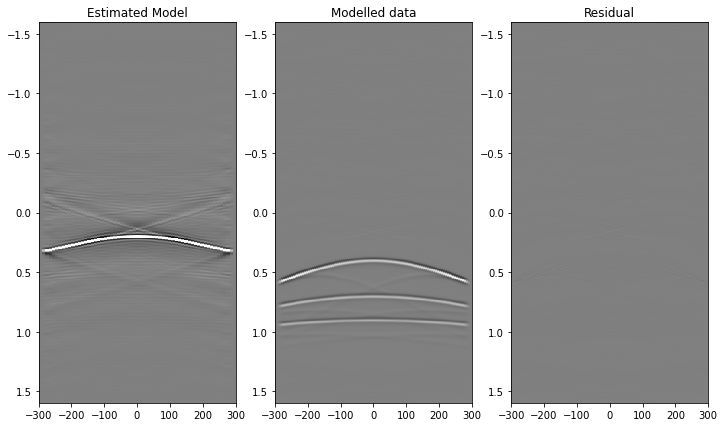

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.max(), vmax=d.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.max(), vmax=d.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## SGD with momentum

In [12]:
lr = 1. / (batch_size * (2*nt-1)) # to match torch notebook

model, dmod, lossdict['SGDMom'], avgdict['SGDMom'], lossepochdict['SGDMom'], enormdict['SGDMom'], _ = \
              MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, SGD, 
                              nepochs, batch_size,
                              mtrue=m, seed=0,
                              **dict(lr=lr, momentum=0.9, nesterov=True))
mdict["SGDMom"] = model

Initial Loss norm: 1.090541e+00
Initial Gradient norm: 4.493770e-02, scaled by lr: 1.596168e-10
epoch:  10, loss : 1.5149e-03, loss avg : 1.9296e-03
epoch:  20, loss : 5.3871e-04, loss avg : 6.2451e-04
epoch:  30, loss : 3.8161e-04, loss avg : 3.8127e-04
Time: 1.275742 s


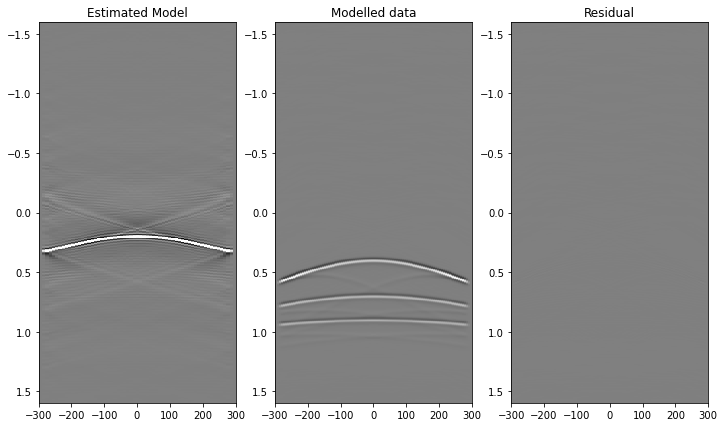

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.max(), vmax=d.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.max(), vmax=d.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

## SGD with momentum and exponential LR

In [14]:
lr = 1. / (batch_size * (2*nt-1)) # to match torch notebook

model, dmod, lossdict['SGDMom_LRexp'], avgdict['SGDMom_LRexp'], lossepochdict['SGDMom_LRexp'], enormdict['SGDMom_LRexp'], lrexp = \
              MDDminibatch(nt, nr, dt, dr, Gwav_fft, d, SGD, 
                           nepochs, batch_size,
                           mtrue=m, seed=0,
                           scheduler=ExponentialLR, 
                           kwargs_sched=dict(gamma=0.99),
                           **dict(lr=lr, momentum=0.9, nesterov=True))
mdict["SGDMom_LRexp"] = model

Initial Loss norm: 1.090541e+00
Initial Gradient norm: 4.493770e-02, scaled by lr: 1.596168e-10
epoch:  10, loss : 1.6797e-03, loss avg : 2.1498e-03
epoch:  20, loss : 8.5733e-04, loss avg : 1.0077e-03
epoch:  30, loss : 7.6994e-04, loss avg : 7.7904e-04
Time: 1.321995 s


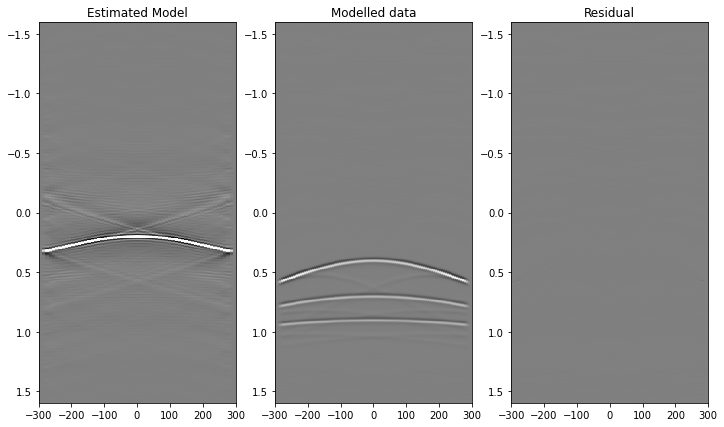

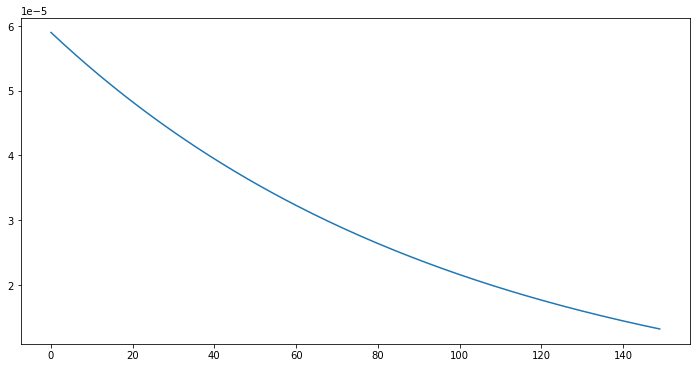

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12,7))
ax1.imshow(model, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.1, vmax=0.1,
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax1.set_title('Estimated Model')
ax2.imshow(dmod, aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.max(), vmax=d.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax2.set_title('Modelled data')
ax3.imshow((dmod-d), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-d.max(), vmax=d.max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))
ax3.set_title('Residual');

fig = plt.figure(figsize= (12,6))
plt.plot(lrexp);

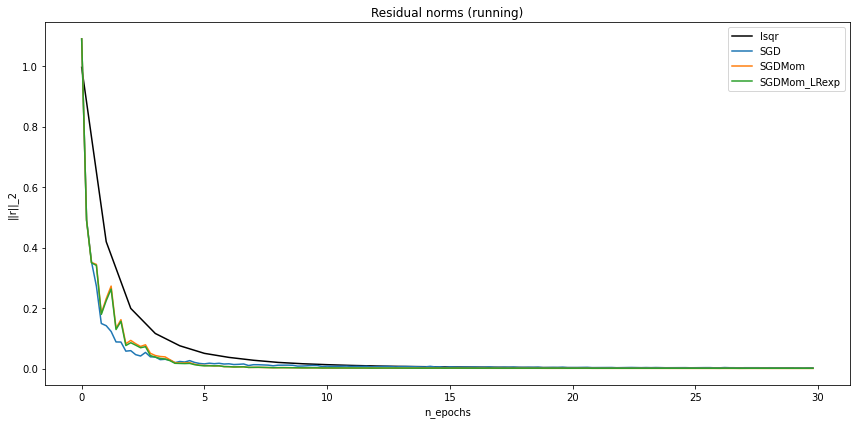

In [16]:
fig = plt.figure(figsize= (12,6))
plt.plot(lsqr_cost[:nepochs], 'k', label='lsqr')
for loss in lossdict.keys():
    plt.plot(np.arange(len(lossdict[loss]))/no_of_batches, 
             np.array(lossdict[loss]) / ((2 * nt - 1) * batch_size), 
             label=str(loss).split()[0])
plt.xlabel('n_epochs')
plt.ylabel('||r||_2')
plt.title('Residual norms (running)')
plt.legend()
plt.tight_layout()

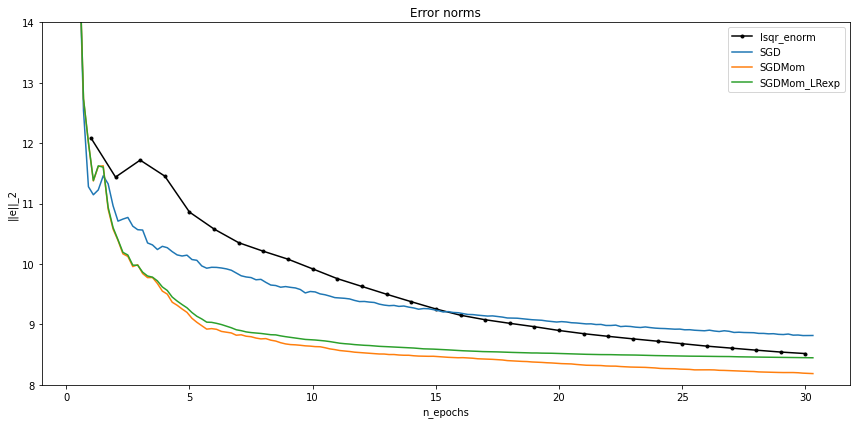

In [17]:
fig = plt.figure(figsize= (12,6))
plt.plot(np.arange(nepochs)+1, lsqr_enorm[:nepochs], '.-k', label = "lsqr_enorm")
for enorm in ['SGD', 'SGDMom', 'SGDMom_LRexp']:
    plt.plot(np.arange(len(enormdict[enorm]))/no_of_batches + 0.5, enormdict[enorm], label=enorm)
plt.ylabel('||e||_2')
plt.xlabel('n_epochs')
plt.title('Error norms')
plt.legend()
plt.ylim(8, 14)
plt.tight_layout()